In [16]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
from datetime import datetime
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [4]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
# Segments id -> name mapping
seg_lst = config['segments']
# seg_lst

In [6]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [7]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [8]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle


In [10]:
pcloud = pd.DataFrame(scan[:, :3], columns=['x', 'y', 'z'])
pcloud = pyntcloud.PyntCloud(pcloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.14305366575717926, 59.59479224681854, 3.6…

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [470]:
from pipeline import common
common = imp.reload(common)

In [573]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    
    n = 1000
    
    # ROI filtering
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    roi_time = (datetime.now() - start_time).total_seconds()
    

    # Obstacles filtering
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pyntcloud.PyntCloud(pcloud)
    obstacle_time = (datetime.now() - start_time).total_seconds()
    
    if len(pcloud.points) > 0:
        
        # Getting voxel grid
        start_time = datetime.now()
        voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                         n_y=params['y_voxels'],
                                                         n_z=params['z_voxels'])
        voxel_time = (datetime.now() - start_time).total_seconds()

        # Сlustering obstacles
        start_time = datetime.now()
        cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
        cluster_time = (datetime.now() - start_time).total_seconds()

        # Getting cluster min max points fot bounding boxes
        start_time = datetime.now()
        pcloud.points['norm'] = np.sqrt(np.square(pcloud.points[['x', 'y', 'z']]).sum(axis=1))
        clusters = pd.DataFrame.from_dict({key: [] for key in pcloud.points.columns})
        for _id in pcloud.points[cluster_id].unique():
            tcluster = common.outlier_filter(pcloud.points[pcloud.points[cluster_id] == _id],
                                             verbose=False)
            clusters = clusters.append(tcluster)
        
        clusters = clusters.groupby([cluster_id]).agg({ 'x': ['min', 'max'],
                                                      'y': ['min', 'max'],
                                                      'z': ['min', 'max'] }).values
        
        cluster_data = pcloud.points[['x', 'y', 'z', cluster_id]]
        cluster_data = cluster_data.rename(columns ={cluster_id: 'cluster_id'})
        min_max_time = (datetime.now() - start_time).total_seconds()
    else:
        clusters, cluster_data = np.empty((0, 0)), np.empty((0, 0))
        voxel_time, cluster_time, min_max_time = 0, 0, 0
        
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f} ms'.format(roi_time))
        print('\n - Filtering obstacles: {:.5f} ms'.format(obstacle_time))
        print('\n - Voxel grid: {:.5f} ms'.format(voxel_time))
        print('\n - Clustering: {:.5f} ms'.format(cluster_time))
        print('\n - Min-max cluster points: {:.5f} ms \n'.format(min_max_time))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time,
                                        'filter_obstacle_time': obstacle_time,
                                        'voxel_grid_time': voxel_time,
                                        'clustering_time': cluster_time,
                                        'outlier_filter_bbox_time': min_max_time}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [574]:
%time 
num='001'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 18.1 µs


In [580]:
%%time
params = {'x_voxels': 24, 'y_voxels': 30, 'z_voxels': 3, 
          'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -14, 'roi_y_max': 14,
          'roi_z_min': -1.25, 'roi_z_max': 1}          
clusters, _, t = pipeline_optimized(scan, label, obstacle_lst, verbose=True, 
                                    exec_time=True, **params)

Execution time:

 - ROI filtering: 0.01871 ms

 - Filtering obstacles: 0.05320 ms

 - Voxel grid: 0.00167 ms

 - Clustering: 0.11541 ms

 - Min-max cluster points: 0.12417 ms 

CPU times: user 313 ms, sys: 0 ns, total: 313 ms
Wall time: 316 ms


In [581]:
sum(t.values())

0.313168

In [577]:
%%timeit
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, verbose=False, **params)

343 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [578]:
records = []
for x in clusters:
    for y in x:
        records.append(y)

In [579]:
clusters.shape

(7, 6)

In [510]:
%time box_coord_list = common.get_bounding_boxes(rec)
print('It is {} clusters'.format(len(box_coord_list)))

ValueError: not enough values to unpack (expected 6, got 3)

It is 10 clusters


In [511]:
# %time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
# print(len(box_coord_list))

In [512]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(6.123188670841857, 6.490692075513097, -0.792…

In [45]:
# cluster_data

In [189]:
from scripts import draw
draw = imp.reload(draw)

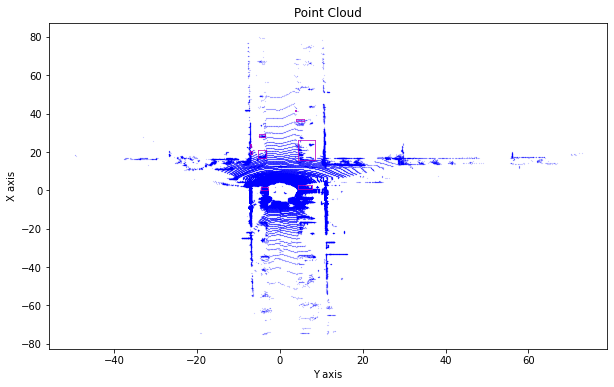

In [190]:
%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [191]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 121333 and after filtering: 22872
CPU times: user 248 ms, sys: 1.98 ms, total: 250 ms
Wall time: 251 ms


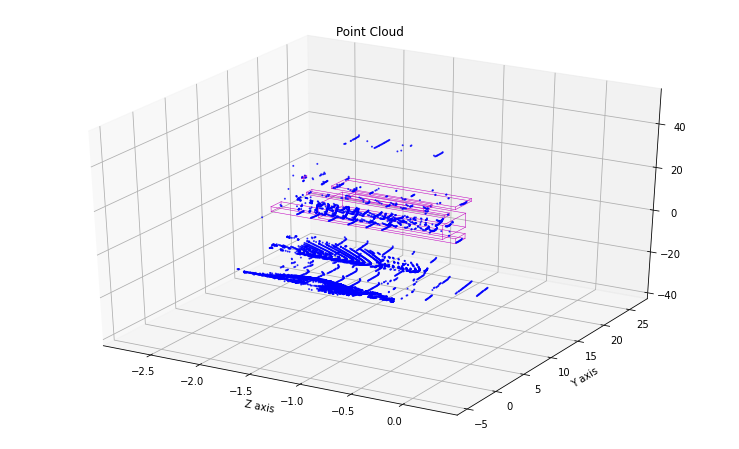

In [49]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [2,1,0]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

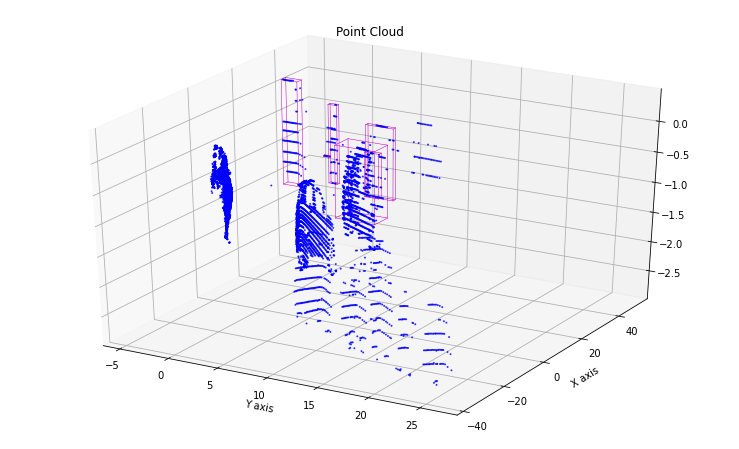

In [50]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [1,0,2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Grid Search Optimization

In [1485]:
help(test.grid_search_optimization)

Help on function grid_search_optimization in module scripts.test:

grid_search_optimization(scan, label, obstacle_lst, pipeline, params, verbose=True)
    Grid Search of hyperparametrs for optimization of executional time of pipeline
    
    scan: numpy.array,
    An N X 3 array of point cloud from LIDAR
    
    label: numpy.array,
    A list of segmentation labels respectively
    
    obstacle_lst: list,
    A list of obstacles id
    
    pipeline: function,
    An obstacle-detection pipeline function
    
    params: dict,
    A dictionary of params range that is reqired to search
    
    verbose: bool, optional, defualt True
    Whether or not print info during execution.



In [ ]:
from scripts import test
test = imp.reload(test)
range_params  = { 'x_voxels': [25, 26, 27], 'y_voxels': [28, 30, 31], 
                  'z_voxels': [3, 4, 6, 7, 8, 9], 
                  'roi_x_min': [0], 'roi_x_max': [45],
                  'roi_y_min': [-14], 'roi_y_max': [14],
                  'roi_z_min': [-2], 'roi_z_max': [1]}
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized, 
                                              range_params, verbose=False)

In [436]:
sorted_exec_dct = {k: v for k, v in sorted(time_exec_lst.items(), key=lambda item: item[1][0])}

In [ ]:
for key in sorted_exec_dct:
    print(key,'Time and n clusters', sorted_exec_dct[key])

## Getting bounding boxes and grep statistics for sequence 

In [514]:
import glob
scan_lst = sorted(glob.glob("../dataset/sequences/00/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/00/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [582]:
from scripts import test
test = imp.reload(test)

In [583]:
# help(test.get_bbox_and_stat)

In [584]:
%%time
# n_scan = -1
write_path = '../dataset/sequences/00/clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                        pipeline_optimized, 
                                                        write_path=write_path, detailed=True, **params)


CPU times: user 2min 55s, sys: 5.42 s, total: 3min 1s
Wall time: 3min 28s


In [542]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

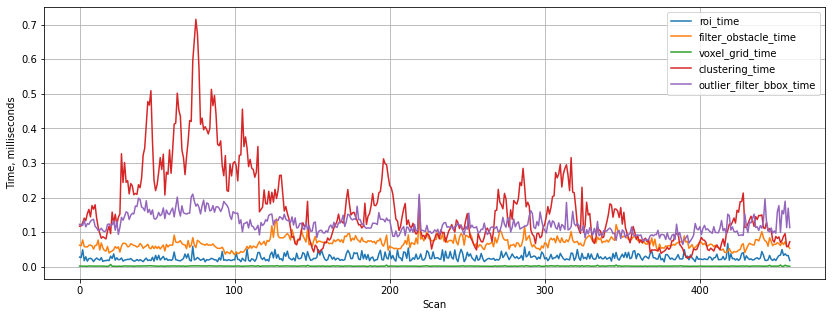

In [543]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, milliseconds')
plt.grid()
plt.show()

In [544]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 0.172418 ms
Mean process time 0.388706697167756 ms
Max process time 0.970109 ms


In [545]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

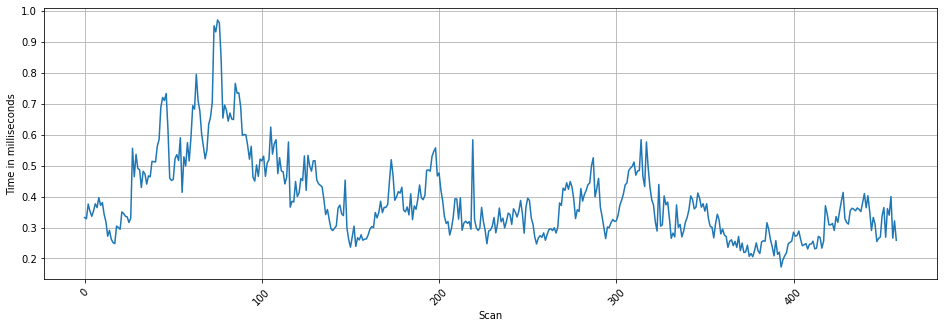

In [546]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in milliseconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time

In [442]:
exec_lst = []
n_epoch = 3
for i in range(n_epoch):
    _, exec_time_dct = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                              pipeline_optimized, write_path=None,
                                                                  x_voxels=25,
                                                                  y_voxels=20,
                                                                  z_voxels=5)
    exec_lst.append(exec_time_dct)

In [452]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append([tdelta.microseconds for tdelta in epoch.values()])
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [454]:
several_exec_time_lst[:3]

[(387403, 382174, 361611), (418736, 408954, 395278), (383912, 373594, 357415)]

In [457]:
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

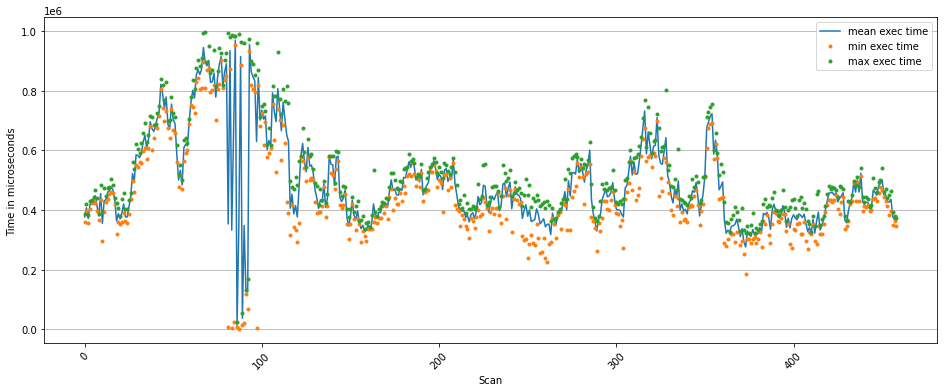

In [464]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
ax = plt.axes()        
ax.yaxis.grid()
plt.xticks(rotation=45)
plt.xlabel('Scan')
plt.ylabel('Time in microseconds')
plt.legend()
plt.show()